In [136]:
from pathlib import Path
from typing import Dict, Tuple, List, Iterable, Mapping, Optional, Sequence
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("runs")
AMPAR_VALUES: List[float] = [1.0,0.63]
RIN_VALUES: List[float] = [1.0, 1.22]
ETA_VALUES: List[float] = [0.0, 0.1]
TEMP_VALUES: List[float] = [0.0, 0.01]
IDIR_VALUES: List[float] = [0.50, 0.51, 0.53, 0.55, 0.60, 0.65, 0.70, 0.80, 0.90]
TRIAL_INDICES: List[int] = list(range(20))  # trial00 … trial19
# ----------------------------------------------------------------------------

def run_id(ampar: float, rin: float,sigma_temp:float, sigma_eta: float, idir: float, trial: int) -> str:
    """Build folder name for a simulation run."""
    suffix = "_gain_scan_1_1" if ampar == 1.0 else "_gain_scan_063_122"
    return f"g{ampar:.3f}_rin{rin:.3f}_sigmatemp{sigma_temp:.3f}_sigmaeta{sigma_eta:.3f}_idir{idir:.3f}_trial{trial:02d}{suffix}"


def load_state_matrix(folder: Path) -> np.ndarray:
    """Load a single run’s state history as neurons × generations."""
    history_file = folder / "state_history.npy"
    if not history_file.exists():
        raise FileNotFoundError(f"Missing state history file: {history_file}")
    states = np.load(history_file)  # generations × neurons
    if states.ndim != 2:
        raise ValueError(f"Expected 2‑D array in {history_file}, got {states.shape}")
    return states.T  # neurons × generations


def build_state_tensors(
    runs_dir: Path = RUNS_DIR,
    ampar_values: Iterable[float] = AMPAR_VALUES,
    rin_values: Iterable[float] = RIN_VALUES,
    eta_values: Iterable[float] = ETA_VALUES,
    temp_values: Iterable[float] = TEMP_VALUES,
    idir_values: Iterable[float] = IDIR_VALUES,
    trials: Iterable[int] = TRIAL_INDICES,
) -> Dict[Tuple[float, float, float, float], np.ndarray]:
    """
    Return tensors keyed by (ampar, rin, sigma_temp, sigma_eta):
      shape = (neurons, generations, trials, idir)
    """
    tensors: Dict[Tuple[float, float, float, float], np.ndarray] = {}
    for ampar in ampar_values:
        for rin in rin_values:
            if (ampar==1.0 and rin==1.22) or (ampar==0.63 and rin==1.0):
                continue
            for sigma_temp in temp_values:
                for sigma_eta in eta_values:
                    idir_blocks = []
                    for idir in idir_values:
                        trial_blocks = []
                        for trial in trials:
                            folder = runs_dir / run_id(ampar, rin, sigma_temp, sigma_eta, idir, trial)
                            trial_blocks.append(load_state_matrix(folder))
                        trial_cube = np.stack(trial_blocks, axis=2)  # neurons × generations × trials
                        idir_blocks.append(trial_cube)
                    tensors[(ampar, rin, sigma_temp, sigma_eta)] = np.stack(idir_blocks, axis=3)  # neurons × generations × trials × idir
    return tensors

In [150]:
def smooth_state(state: np.ndarray, window_size: int = 5) -> np.ndarray:
    """
    Rolling mean over generations axis (axis=1); keeps other dims.
    Expects shape (neurons, generations, trials, idir).
    """
    if window_size < 1:
        raise ValueError("window_size must be >= 1")
    cumsum = np.cumsum(state, axis=1)
    cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
    return cumsum[:, window_size - 1:] / window_size

def compute_snr_per_mode(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape

    snr_per_mode = np.zeros((trials, neurons))
    evals_per_mode = np.zeros((trials, neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    for trial in range(trials):
        delta_mu = state[:, :, trial, angle].mean(axis=1) - state[:, :, trial, other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])
        evals, evecs = np.linalg.eigh(covariance)
        for k in range(evals.shape[0]):
            pc = evecs[:, k]
            signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
            snr_per_mode[trial, k] = signal_proj ** 2  # optional: / evals[k]
            evals_per_mode[trial, k] = evals[k]

    return snr_per_mode, evals_per_mode


def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")

    # mean over generations → shape (neurons, trials, idir)
    means = state.mean(axis=1)


    deltas, snrs = [], []

    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    for idir_i, idir_j in combinations(range(idirs), 2):
        delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
        delta_mu = means[:, :, idir_i] - means[:, :, idir_j]  # (neurons, trials)

        for trial in range(trials):
            try:
                evals, evecs = np.linalg.eigh(np.cov(state[:, :, trial, idir_i], ddof=1))
                proj = evecs.T @ delta_mu[:, trial]      # (neurons,)
                snr_trial = np.sum((proj ** 2) / (evals+1e-12))
                deltas.append(delta_idir)
                snrs.append(snr_trial)
            except np.linalg.LinAlgError:
                continue

            # if you also want the symmetric direction, add this block:
            # evals_b, evecs_b = eig_cache[trial][idir_j]
            # proj_b = evecs_b.T @ (-delta_mu[:, trial])  # negative delta
            # snr_b = np.sum((proj_b ** 2) / (evals_b))
            # deltas.append(delta_idir)
            # snrs.append(snr_b)

    return np.asarray(deltas), np.asarray(snrs)


def overlap_function(tensors, ampar, rin, sigma_eta, sigma_temp, idir1, idir2,k=3):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    smoothed_state1 = smooth_state(state1, window_size = 20)
    overlap, evals = compute_snr_per_mode(smoothed_state1,idir_1=idir1,idir_2 = idir2)
    for _ in range(k):
        max_idx = np.argmax(evals, axis=1)
        evals = np.delete(evals, max_idx, axis=1)
        overlap = np.delete(overlap, max_idx, axis=1)

    # Compute means across animals
    mean_evals = evals.mean(axis=0)
    mean_overlap = overlap.mean(axis=0)

    # Linear fit
    a, b = np.polyfit(mean_evals, mean_overlap, deg=1)

    # Generate smooth line
    xfit = np.linspace(mean_evals.min(), mean_evals.max(), 200)
    yfit = a * xfit + b

    return mean_evals, mean_overlap, xfit, yfit, a, b


def snr_delta_function(tensors, ampar, rin, sigma_eta, sigma_temp):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    smoothed_state1 = smooth_state(state1, window_size = 5)
    deltas, snrs = compute_snr_per_delta(smoothed_state1, np.array(IDIR_VALUES))

    unique_deltas = np.unique(deltas)
    avg_snrs = []
    error_snrs = []
    for delta in unique_deltas:
        snr_values = snrs[deltas == delta]
        avg_snrs.append(np.mean(snr_values))
        error_snrs.append(np.std(snr_values) / np.sqrt(len(snr_values)))

    return unique_deltas, np.array(avg_snrs), np.array(error_snrs)

In [70]:
tensors = build_state_tensors()

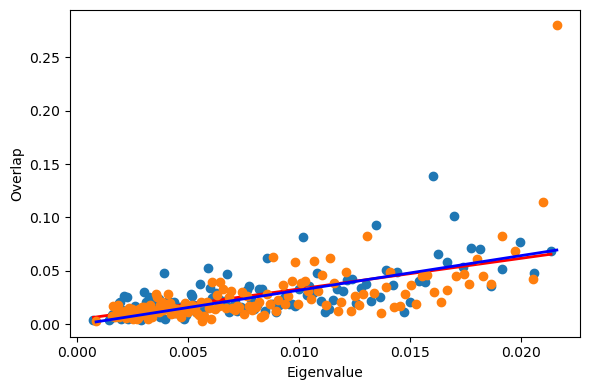

In [133]:
# AMPAR_VALUES: List[float] = [1.0,0.63]
# RIN_VALUES: List[float] = [1.0, 1.22]
# ETA_VALUES: List[float] = [0.0, 0.1]
# TEMP_VALUES: List[float] = [0.0, 0.01]

# Plot Overlap vs Eigenvalues
## For each ampar, rin, sigma_eta, sigma_temp AND IDIR combination
fig, ax = plt.subplots(figsize=(6, 4))

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=0.9
)
ax.plot(mean_evals, mean_overlap, "o")
ax.plot(xfit, yfit, "-", color="red", lw=2)

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=0.63, rin=1.22, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=0.9
)
ax.plot(mean_evals, mean_overlap, "o")
ax.plot(xfit, yfit, "-", color="blue", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()

In [164]:
idir_delta_fr_et_sig, snr_fr_et_sig, error_fr_et_sig = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.1, sigma_temp=0.01)
idir_delta_ctr_et_sig, snr_ctr_et_sig, error_ctr_et_sig = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.1, sigma_temp=0.01)

idir_delta_fr_et, snr_fr_et, error_fr_et = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.1, sigma_temp=0.0)
idir_delta_ctr_et, snr_ctr_et, error_ctr_et = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.1, sigma_temp=0.0)

idir_delta_fr_sig, snr_fr_sig, error_fr_sig = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.0, sigma_temp=0.01)
idir_delta_ctr_sig, snr_ctr_sig, error_ctr_sig = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.0, sigma_temp=0.01)

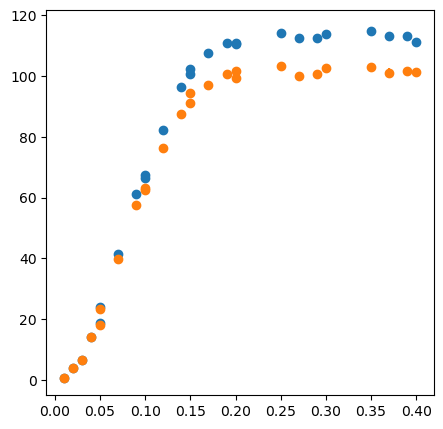

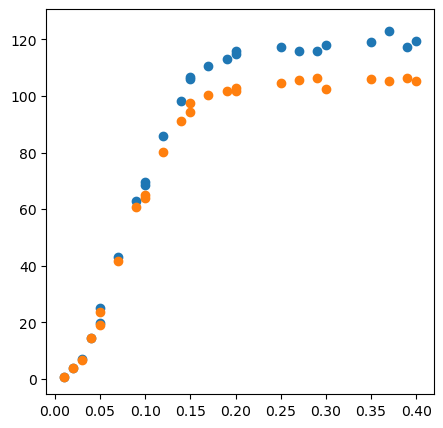

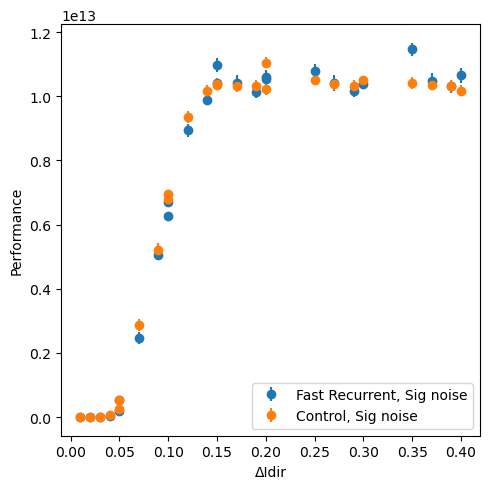

In [177]:
from scipy.stats import norm


# # Plot SNR vs Delta Idir
# ## For each ampar, rin, sigma_eta, sigma_temp combination



def snr_to_perf_and_err(snr, snr_err):
    """
    Convert an SNR value and its error into performance and propagated error.
    SNR error is std of SNR, not variance.
    """
    # Compute d' and performance
    dprime = np.sqrt(snr)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)

    # PDF at z
    pdf = norm.pdf(z)

    # derivative dP/dSNR
    dP_dSNR = pdf * (1 / (2 * np.sqrt(2 * snr)))

    # propagated error
    perf_err = np.abs(dP_dSNR) * snr_err

    # return perf, perf_err
    return snr, snr_err


#Figure 1
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(idir_delta_fr_et_sig, snr_to_perf_and_err(snr_fr_et_sig, error_fr_et_sig)[0], yerr=snr_to_perf_and_err(snr_fr_et_sig, error_fr_et_sig)[1], fmt='o', label='Fast Recurrent, ET noise')
ax.errorbar(idir_delta_ctr_et_sig, snr_to_perf_and_err(snr_ctr_et_sig, error_ctr_et_sig)[0], yerr=snr_to_perf_and_err(snr_ctr_et_sig, error_ctr_et_sig)[1], fmt='o', label='Control, ET noise')

# Figure 2
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(idir_delta_fr_et, snr_to_perf_and_err(snr_fr_et, error_fr_et)[0], yerr=snr_to_perf_and_err(snr_fr_et, error_fr_et)[1], fmt='o', label='Fast Recurrent, ET noise')
ax.errorbar(idir_delta_ctr_et, snr_to_perf_and_err(snr_ctr_et, error_ctr_et)[0], yerr=snr_to_perf_and_err(snr_ctr_et, error_ctr_et)[1], fmt='o', label='Control, ET noise')

# Figure 3
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(idir_delta_fr_sig, snr_to_perf_and_err(snr_fr_sig, error_fr_sig)[0], yerr=snr_to_perf_and_err(snr_fr_sig, error_fr_sig)[1], fmt='o', label='Fast Recurrent, Sig noise')
ax.errorbar(idir_delta_ctr_sig, snr_to_perf_and_err(snr_ctr_sig, error_ctr_sig)[0], yerr= snr_to_perf_and_err(snr_ctr_sig, error_ctr_sig)[1], fmt='o', label='Control, Sig noise')

ax.set_xlabel("ΔIdir")
ax.set_ylabel("Performance")
ax.legend()
fig.tight_layout()



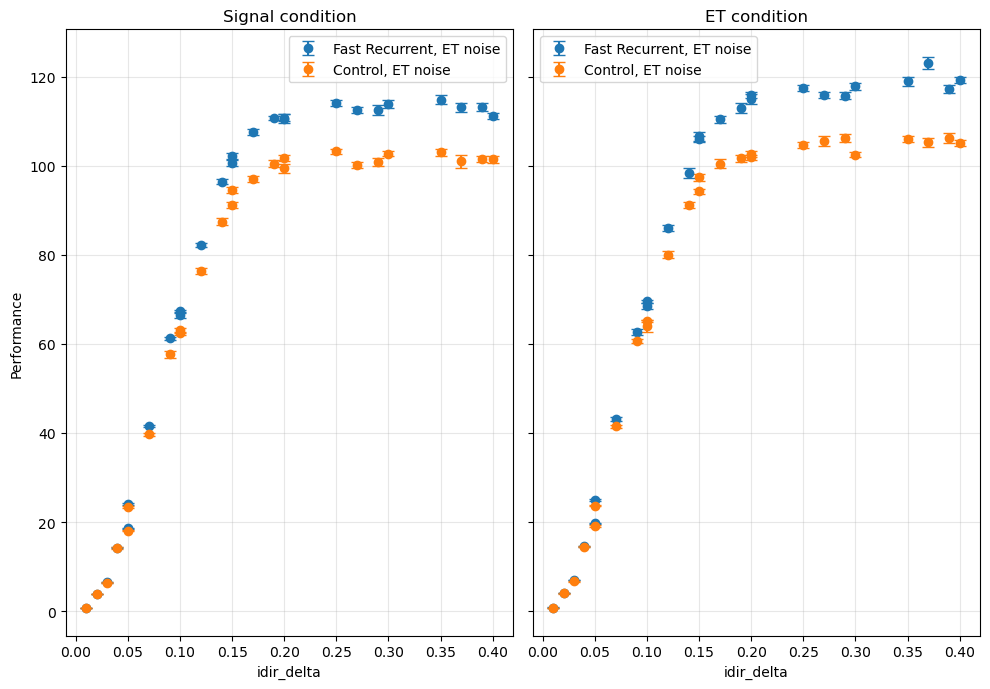

In [180]:
import matplotlib.pyplot as plt

def plot_perf(ax, idir_delta, snr, err, label, color):
    perf, perf_err = snr_to_perf_and_err(snr, err)
    ax.errorbar(
        idir_delta,
        perf,
        yerr=perf_err,
        fmt='o',
        ms=6,
        lw=1.5,
        capsize=4,
        label=label,
        color=color,
    )

fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True, tight_layout=True)

# Figure 1
plot_perf(
    axes[0],
    idir_delta_fr_et_sig,
    snr_fr_et_sig,
    error_fr_et_sig,
    'Fast Recurrent, ET noise',
    '#1f77b4',
)
plot_perf(
    axes[0],
    idir_delta_ctr_et_sig,
    snr_ctr_et_sig,
    error_ctr_et_sig,
    'Control, ET noise',
    '#ff7f0e',
)
axes[0].set_title('Signal condition')
axes[0].set_xlabel('idir_delta')
axes[0].set_ylabel('Performance')
axes[0].grid(True, alpha=0.3)
# axes[0].set_xlim(0,0.06)
axes[0].legend()

# Figure 2
plot_perf(
    axes[1],
    idir_delta_fr_et,
    snr_fr_et,
    error_fr_et,
    'Fast Recurrent, ET noise',
    '#1f77b4',
)
plot_perf(
    axes[1],
    idir_delta_ctr_et,
    snr_ctr_et,
    error_ctr_et,
    'Control, ET noise',
    '#ff7f0e',
)
axes[1].set_title('ET condition')
axes[1].set_xlabel('idir_delta')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
# axes[1].set_xlim(0,0.06)

plt.show()
